In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mat
%matplotlib inline
import seaborn as sns
import sklearn.metrics as metrics

from heapq import nlargest

In [2]:
!pip install --upgrade category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 875 kB/s 


In [3]:
from category_encoders import TargetEncoder
from sklearn.preprocessing import LabelBinarizer

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [5]:
from google.colab import files
uploaded = files.upload()

Saving ITSalaries3.csv to ITSalaries3.csv


In [181]:
df = pd.read_csv('ITSalaries3.csv')
df.head()

,Unnamed: 0,Age,Gender,Position,TotalYearsExperience,YearsExperienceGermany,Seniority,MainSkill,SecondarySkills,BrutSalary,...,ContractDuration,CompanySize,CompanyType,LossOfJobCorona,HoursIfShorterWeek,AdditionalMonetarySupport,SeniorityLevel,EmploymentType,Female,Male
0,0,26.0,Male,Software Engineer,5.0,3.0,Senior,TypeScript,"Kotlin, Javascript / Typescript",80000.0,...,Unlimited contract,51-100,Product,No,13.566568,250.0,3,4,0,1
1,1,26.0,Male,Backend Developer,7.0,4.0,Senior,Ruby,NaN,80000.0,...,Unlimited contract,101-1000,Product,No,13.566568,250.0,3,4,0,1
2,2,28.0,Male,Frontend Developer,4.0,1.0,Junior,Javascript,NaN,54000.0,...,Unlimited contract,51-100,Startup,No,13.566568,250.0,1,4,0,1
3,3,37.0,Male,Backend Developer,17.0,6.0,Senior,C# .NET,".NET, SQL, AWS, Docker",62000.0,...,Unlimited contract,101-1000,Product,No,13.566568,250.0,3,4,0,1
4,4,32.0,Male,DevOps,5.0,1.0,Senior,"AWS, GCP, Python,K8s","Python, AWS, Google Cloud, Kubernetes, Docker",76000.0,...,Unlimited contract,11-50,Startup,No,13.566568,250.0,3,4,0,1


In [182]:
df.select_dtypes(include=object).head(5)

,Gender,Position,Seniority,MainSkill,SecondarySkills,VacationDays,Employment,ContractDuration,CompanySize,CompanyType,LossOfJobCorona
0,Male,Software Engineer,Senior,TypeScript,"Kotlin, Javascript / Typescript",30,Full-time employee,Unlimited contract,51-100,Product,No
1,Male,Backend Developer,Senior,Ruby,NaN,28,Full-time employee,Unlimited contract,101-1000,Product,No
2,Male,Frontend Developer,Junior,Javascript,NaN,24,Full-time employee,Unlimited contract,51-100,Startup,No
3,Male,Backend Developer,Senior,C# .NET,".NET, SQL, AWS, Docker",29,Full-time employee,Unlimited contract,101-1000,Product,No
4,Male,DevOps,Senior,"AWS, GCP, Python,K8s","Python, AWS, Google Cloud, Kubernetes, Docker",30,Full-time employee,Unlimited contract,11-50,Startup,No


In [183]:
# Seems like the index got messed up when we exported our dataframe
df = df.reset_index(drop=True)
df = df.iloc[: , 1:]

In [184]:
df.columns

Index(['Age', 'Gender', 'Position', 'TotalYearsExperience',
       'YearsExperienceGermany', 'Seniority', 'MainSkill', 'SecondarySkills',
       'BrutSalary', 'BrutSalaryAndStocks', 'AnnualBrutLastYear',
       'AnnualBrutAndStocksLastYear', 'VacationDays', 'Employment',
       'ContractDuration', 'CompanySize', 'CompanyType', 'LossOfJobCorona',
       'HoursIfShorterWeek', 'AdditionalMonetarySupport', 'SeniorityLevel',
       'EmploymentType', 'Female', 'Male'],
      dtype='object')

In [185]:
df = df.drop(['Gender', 'Seniority', 'Employment'], axis=1)

In [186]:
# Let's fix the last of our categorical columns
df.select_dtypes(include=['object'])

,Position,MainSkill,SecondarySkills,VacationDays,ContractDuration,CompanySize,CompanyType,LossOfJobCorona
0,Software Engineer,TypeScript,"Kotlin, Javascript / Typescript",30,Unlimited contract,51-100,Product,No
1,Backend Developer,Ruby,NaN,28,Unlimited contract,101-1000,Product,No
2,Frontend Developer,Javascript,NaN,24,Unlimited contract,51-100,Startup,No
3,Backend Developer,C# .NET,".NET, SQL, AWS, Docker",29,Unlimited contract,101-1000,Product,No
4,DevOps,"AWS, GCP, Python,K8s","Python, AWS, Google Cloud, Kubernetes, Docker",30,Unlimited contract,11-50,Startup,No
...,...,...,...,...,...,...,...,...
1081,Backend Developer,Java,"Python, Javascript / Typescript, Java / Scala,...",26,Unlimited contract,51-100,Product,Yes
1082,Researcher/ Consumer Insights Analyst,consumer analysis,NaN,unlimited,Unlimited contract,1000+,Product,No
1083,IT Operations Manager,PHP,"Python, C/C++, Javascript / Typescript, Java /...",28,Unlimited contract,101-1000,eCommerce,No
1084,Frontend Developer,JavaScript,"Javascript / Typescript, Docker, HTML, CSS; Ad...",27,Unlimited contract,101-1000,Product,No


### Position

In [187]:
# How many unique positions are there?
df["Position"].nunique()

124

In [188]:
# Top Positions
df["Position"].value_counts()[:10]

Software Engineer     344
Backend Developer     160
Data Scientist         91
Frontend Developer     78
QA Engineer            60
DevOps                 52
Mobile Developer       47
ML Engineer            36
Product Manager        30
Data Engineer          22
Name: Position, dtype: int64

In [189]:
encoder = TargetEncoder()
df['Position'] = encoder.fit_transform(df['Position'], df['BrutSalary'])

/usr/local/lib/python3.7/dist-packages/category_encoders/target_encoder.py:124: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/category_encoders/target_encoder.py:129: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)


### Main and Secondary Skill

In [190]:
# Top Skills
df["MainSkill"].value_counts()[:10]

Java          165
Python        137
PHP            52
C++            35
JavaScript     31
Javascript     30
C#             27
python         21
Swift          20
Scala          20
Name: MainSkill, dtype: int64

In [191]:
df['MainSkill'] = encoder.fit_transform(df['MainSkill'], df['BrutSalary'])
df['SecondarySkills'] = encoder.fit_transform(df['SecondarySkills'], df['BrutSalary'])

### Vacation Days

In [192]:
for x in df['VacationDays']:
  try:
    x = float(x)
  except:
    print(x)

unlimited 
30 in contract (but theoretically unlimited)
~25
unlimited
23+
Unlimited
24 labour days
Unlimited
unlimited
unlimited 


In [193]:
df = df.replace({'VacationDays' : { "30 in contract (but theoretically unlimited)" : 30, "~25" : 25,
                                   "23+": 23, "unlimited": np.Inf, "24 labour days": 24, 'unlimited ': np.Inf,
                                   "Unlimited": np.Inf, "Unlimited ": np.Inf, "NaN": 0}})
df['VacationDays'] = df['VacationDays'].astype(float)

### Contract Duration

In [194]:
df["ContractDuration"].nunique()

2

In [195]:
fill = df['ContractDuration'].mode()
fill

0    Unlimited contract
dtype: object

In [196]:
df['ContractDuration'] = df['ContractDuration'].fillna(fill)

In [197]:
y = pd.get_dummies(df['ContractDuration'], prefix='Type')

In [198]:
df = pd.concat([df, y], axis=1)

In [199]:
df.head()

,Age,Position,TotalYearsExperience,YearsExperienceGermany,MainSkill,SecondarySkills,BrutSalary,BrutSalaryAndStocks,AnnualBrutLastYear,AnnualBrutAndStocksLastYear,...,CompanyType,LossOfJobCorona,HoursIfShorterWeek,AdditionalMonetarySupport,SeniorityLevel,EmploymentType,Female,Male,Type_Temporary contract,Type_Unlimited contract
0,26.0,71777.000000,5.0,3.0,76840.582037,72892.687548,80000.0,5000.0,75000.0,10000.0,...,Product,No,13.566568,250.0,3,4,0,1,0,1
1,26.0,69657.018750,7.0,4.0,70149.999992,65895.882353,80000.0,5000.0,82000.0,5000.0,...,Product,No,13.566568,250.0,3,4,0,1,0,1
2,28.0,64336.602564,4.0,1.0,65788.666667,65895.882353,54000.0,5000.0,65000.0,5000.0,...,Startup,No,13.566568,250.0,1,4,0,1,0,1
3,37.0,69657.018750,17.0,6.0,69636.731123,69636.731123,62000.0,5000.0,62000.0,5000.0,...,Product,No,13.566568,250.0,3,4,0,1,0,1
4,32.0,73111.538462,5.0,1.0,69636.731123,70250.296314,76000.0,5000.0,76000.0,5000.0,...,Startup,No,13.566568,250.0,3,4,0,1,0,1


### Company Type

In [200]:
df["CompanyType"].unique()

array(['Product', 'Startup', 'Consulting / Agency', 'Media', nan,
       'Personal Ltd', 'Cloud', 'Behörde', 'Construction',
       'Big commercial', 'Outsorce', 'Bank ', 'Automotive', 'Bank',
       'IT Department of established business', 'Telecommunications',
       'Systemhaus', 'University', 'IT-Outsourcing', 'Game Company',
       'Financial ', 'E-commerce', 'Corporation',
       'Publishing and Technology', 'Market Research ', 'e-commerce',
       'SaaS', 'Publisher', 'Energy ', 'Enterprise', 'Bloody enterprise',
       'service', 'Utilities', 'Insurance', 'Research institute',
       'Retail', 'Ecommerce', 'E-Commerce', 'Semiconductor',
       'Automotive ', 'Institute', 'Finance', 'Fintech', 'Handel ',
       'Consulting and Product', 'Education', 'Pharma',
       'Transport & Logistics', 'Biergarten ', 'Research',
       'Multinational ', 'Industry', 'FAANG', 'Old industry', 'Outsourse',
       'eCommerce'], dtype=object)

In [201]:
df["CompanyType"] = encoder.fit_transform(df["CompanyType"], df['BrutSalary'])

### Loss of Jobs

In [202]:
df["LossOfJobCorona"].unique()

array(['No', 'Yes',
       "i didn't but will be looking for new one because of covid", nan,
       'kurzarbeitzeit for 1.5 months',
       'No, but there was a salary cut at 10% for 3 months and then at 5% for further 3 months',
       'Lost the job but for different reason',
       'yes but found a new one with better pay / perks'], dtype=object)

In [203]:
keep = ['No', 'Yes']
fill = df['LossOfJobCorona'].mode()
df.loc[~df['LossOfJobCorona'].isin(keep), 'LossOfJobCorona'] = df['LossOfJobCorona'].mode()
df['LossOfJobCorona'] = df['LossOfJobCorona'].fillna(fill)

In [204]:
y = pd.get_dummies(df['LossOfJobCorona'], prefix='LossOfJobCorona')

In [205]:
df = pd.concat([df, y], axis=1)
df.head()

,Age,Position,TotalYearsExperience,YearsExperienceGermany,MainSkill,SecondarySkills,BrutSalary,BrutSalaryAndStocks,AnnualBrutLastYear,AnnualBrutAndStocksLastYear,...,HoursIfShorterWeek,AdditionalMonetarySupport,SeniorityLevel,EmploymentType,Female,Male,Type_Temporary contract,Type_Unlimited contract,LossOfJobCorona_No,LossOfJobCorona_Yes
0,26.0,71777.000000,5.0,3.0,76840.582037,72892.687548,80000.0,5000.0,75000.0,10000.0,...,13.566568,250.0,3,4,0,1,0,1,1,0
1,26.0,69657.018750,7.0,4.0,70149.999992,65895.882353,80000.0,5000.0,82000.0,5000.0,...,13.566568,250.0,3,4,0,1,0,1,1,0
2,28.0,64336.602564,4.0,1.0,65788.666667,65895.882353,54000.0,5000.0,65000.0,5000.0,...,13.566568,250.0,1,4,0,1,0,1,1,0
3,37.0,69657.018750,17.0,6.0,69636.731123,69636.731123,62000.0,5000.0,62000.0,5000.0,...,13.566568,250.0,3,4,0,1,0,1,1,0
4,32.0,73111.538462,5.0,1.0,69636.731123,70250.296314,76000.0,5000.0,76000.0,5000.0,...,13.566568,250.0,3,4,0,1,0,1,1,0


### Company Size

In [206]:
df['CompanySize'].unique

<bound method Series.unique of 0         51-100
1       101-1000
2         51-100
3       101-1000
4          11-50
          ...   
1081      51-100
1082       1000+
1083    101-1000
1084    101-1000
1085      51-100
Name: CompanySize, Length: 1086, dtype: object>

In [207]:
df['CompanySize'] = encoder.fit_transform(df['CompanySize'], df['BrutSalary'])

In [208]:
df.dtypes

Age                            float64
Position                       float64
TotalYearsExperience           float64
YearsExperienceGermany         float64
MainSkill                      float64
SecondarySkills                float64
BrutSalary                     float64
BrutSalaryAndStocks            float64
AnnualBrutLastYear             float64
AnnualBrutAndStocksLastYear    float64
VacationDays                   float64
ContractDuration                object
CompanySize                    float64
CompanyType                    float64
LossOfJobCorona                 object
HoursIfShorterWeek             float64
AdditionalMonetarySupport      float64
SeniorityLevel                   int64
EmploymentType                   int64
Female                           int64
Male                             int64
Type_Temporary contract          uint8
Type_Unlimited contract          uint8
LossOfJobCorona_No               uint8
LossOfJobCorona_Yes              uint8
dtype: object

In [209]:
df = df.drop(['ContractDuration', 'LossOfJobCorona'], axis=1)

In [210]:
df[df.isin([np.Inf]).any(axis=1)]

,Age,Position,TotalYearsExperience,YearsExperienceGermany,MainSkill,SecondarySkills,BrutSalary,BrutSalaryAndStocks,AnnualBrutLastYear,AnnualBrutAndStocksLastYear,...,HoursIfShorterWeek,AdditionalMonetarySupport,SeniorityLevel,EmploymentType,Female,Male,Type_Temporary contract,Type_Unlimited contract,LossOfJobCorona_No,LossOfJobCorona_Yes
336,31.000000,71777.000000,11.0,1.0,67670.905109,68772.489878,75000.0,5000.0,65000.0,5000.0,...,13.566568,250.0,2,4,0,1,0,1,1,0
677,39.000000,71777.000000,19.0,7.0,80819.861250,69636.731123,87000.0,97000.0,82000.0,92000.0,...,40.000000,500.0,3,4,0,1,0,1,1,0
799,38.000000,71777.000000,12.0,6.0,70612.933333,76197.651996,92000.0,40000.0,85000.0,30000.0,...,13.566568,250.0,3,4,0,1,0,1,1,0
834,31.000000,69636.731123,10.0,2.0,67670.905109,65895.882353,80000.0,0.0,78000.0,5000.0,...,13.566568,250.0,2,4,0,1,0,1,1,0
845,32.568935,66232.417582,4.0,4.0,66380.952388,78079.651734,105000.0,0.0,85000.0,0.0,...,13.566568,250.0,2,4,0,1,0,1,1,0
1082,33.000000,69636.731123,10.0,1.5,69636.731123,65895.882353,60000.0,3000.0,48000.0,2500.0,...,13.566568,0.0,3,4,0,1,0,1,1,0


In [211]:
df = df.drop([df.index[336], df.index[677], df.index[799], df.index[834]
         , df.index[845], df.index[1082]])
df = df.reset_index(drop=True)
df = df.iloc[: , 1:]

In [212]:
ind = df[df.isna().any(axis=1)].index
df = df.drop(ind, axis = 0)

In [213]:
df = df.reset_index(drop=True)
df = df.iloc[: , 1:]

In [214]:
df.shape

(1031, 21)

In [215]:
men = df[df['Male'] == 1].shape[0]
men

890

In [216]:
women = df[df['Female'] == 1].shape[0]
women

141

# MODELS
##### We are now trying to predict salary!

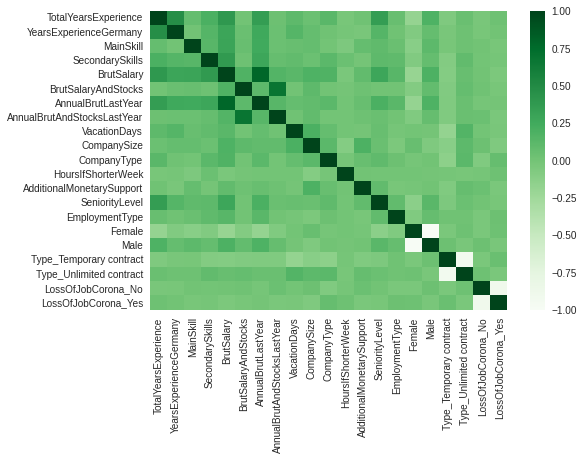

In [217]:
correlations = df.corr()
sns.heatmap(correlations, cmap = "Greens")

In [218]:
# Selecting target and predictors
X = df.drop(['Male', 'Female'], axis = 1).to_numpy()
Y = df['Male'].to_numpy()

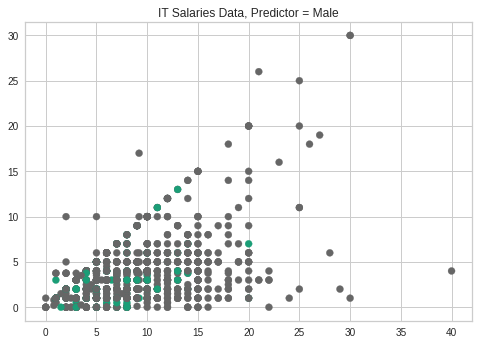

In [219]:
plt.scatter(X[:,0],X[:,1],  c= df['Male'], cmap =  'Dark2')
plt.title("IT Salaries Data, Predictor = Male")
plt.show()

In [220]:
males = df[df['Male'] == 1].shape[0]

In [221]:
X = df.drop(['Male', 'Female'], axis = 1)
Y = df['Male']

### Model Comparison

In [222]:
def model(X, y, n_splits, model, printing):
  k_folds = KFold(n_splits = n_splits)
  acc_score = []
  cm = 0

  for train_index , test_index in k_folds.split(X):
      X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
      y_train , y_test = y[train_index] , y[test_index]

      if model == "knn":
        error = []
        fold = 1
        for k in range(1,10):
          knn = KNeighborsClassifier(n_neighbors = k)
          knn.fit(X_train, y_train)
          pred_values = knn.predict(X_test)
          error.append(np.mean(pred_values != y_test))
          
        cm = confusion_matrix(y_test, pred_values)
        plt.errorbar(y_test, pred_values, yerr=0.8, fmt='.k')
        
        if printing == 1:
          print("Minimum error:-",min(error),"at K =",error.index(min(error)))
          
      elif model == 'lda':
        sc = StandardScaler()
        X_train = sc.fit_transform(X_train)
        X_test = sc.transform(X_test)
        lda = LDA(n_components=1)
        X_train = lda.fit_transform(X_train, y_train)
        X_test = lda.transform(X_test)
        
        classifier = RandomForestClassifier(max_depth=2, random_state=0)
        classifier.fit(X_train, y_train)
        pred_values = classifier.predict(X_test)
        cm = confusion_matrix(y_test, pred_values)
        plt.errorbar(y_test, pred_values, yerr=0.8, fmt='.k');

      elif model == 'reg':
        sc = StandardScaler()
        X_train = sc.fit_transform(X_train)
        X_test = sc.transform(X_test)
        logreg = LogisticRegression(solver='lbfgs', max_iter=100)
        logreg.fit(X_train, y_train)
        pred_values = logreg.predict(X_test)
        cm = confusion_matrix(y_test, pred_values)
        plt.errorbar(y_test, pred_values, yerr=0.8, fmt='.k')



      acc = accuracy_score(pred_values , y_test)
      acc_score.append(acc)
     
  avg_acc_score = sum(acc_score)/n_splits

  if printing == 1:
    report = metrics.classification_report(y_test, pred_values)
    print("Model:", model)
    print('accuracy of each fold - {}'.format(acc_score))
    print('Avg accuracy : {}'.format(avg_acc_score))
    print(metrics.classification_report(y_test, pred_values))
    return cm, report

  else:
    report = metrics.classification_report(y_test, pred_values)
    return avg_acc_score, report, cm


Minimum error:- 0.15942028985507245 at K = 6
Minimum error:- 0.13592233009708737 at K = 8
Minimum error:- 0.15048543689320387 at K = 8
Minimum error:- 0.14563106796116504 at K = 2
Minimum error:- 0.1407766990291262 at K = 7
Model: knn

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat


accuracy of each fold - [0.8357487922705314, 0.8640776699029126, 0.8495145631067961, 0.8495145631067961, 0.8592233009708737]
Avg accuracy : 0.851615777871582
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        29
           1       0.86      1.00      0.92       177

    accuracy                           0.86       206
   macro avg       0.43      0.50      0.46       206
weighted avg       0.74      0.86      0.79       206



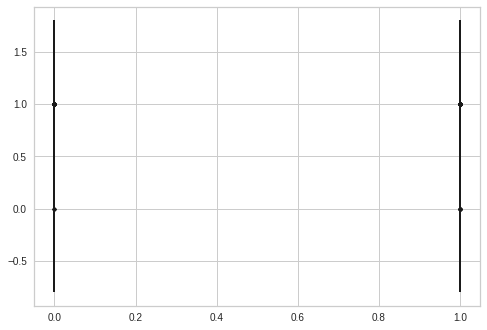

In [223]:
cm, report = model(X, Y, 5, "knn", 1)

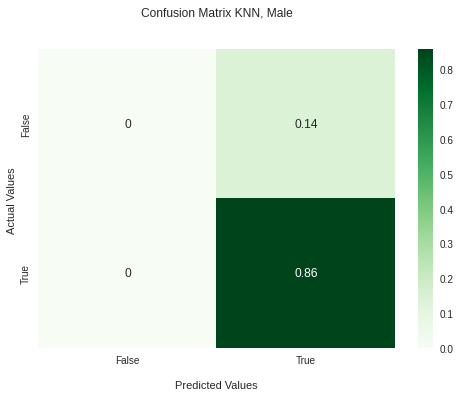

In [224]:
ax = sns.heatmap(cm/np.sum(cm), annot=True,  cmap="Greens")
ax.set_title('Confusion Matrix KNN, Male\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Model: lda
accuracy of each fold - [0.8454106280193237, 0.8737864077669902, 0.8640776699029126, 0.8737864077669902, 0.8592233009708737]
Avg accuracy : 0.8632568828854181
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        29
           1       0.86      1.00      0.92       177

    accuracy                           0.86       206
   macro avg       0.43      0.50      0.46       206
weighted avg       0.74      0.86      0.79       206



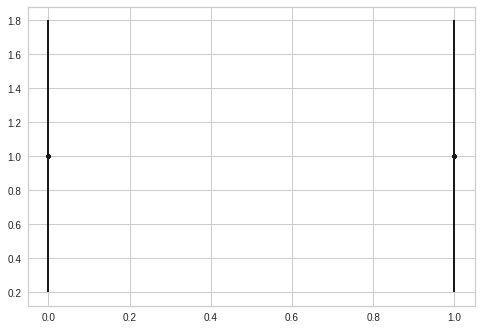

In [225]:
cmm_lda, rep = model(X, Y, 5, "lda", 1)

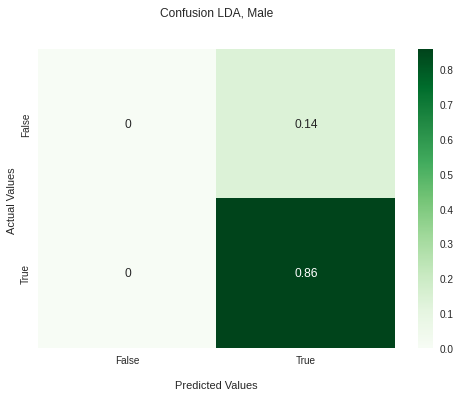

In [226]:
ax = sns.heatmap(cmm_lda/np.sum(cmm_lda), annot=True,  cmap="Greens")
ax.set_title('Confusion LDA, Male\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

Model: reg
accuracy of each fold - [0.8454106280193237, 0.8592233009708737, 0.8640776699029126, 0.8689320388349514, 0.8446601941747572]
Avg accuracy : 0.8564607663805637
              precision    recall  f1-score   support

           0       0.29      0.07      0.11        29
           1       0.86      0.97      0.91       177

    accuracy                           0.84       206
   macro avg       0.58      0.52      0.51       206
weighted avg       0.78      0.84      0.80       206



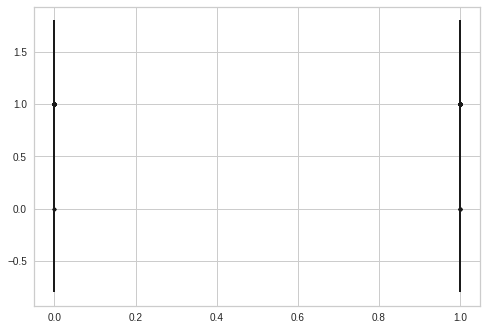

In [227]:
cmm_reg, rep = model(X, Y, 5, "reg", 1)

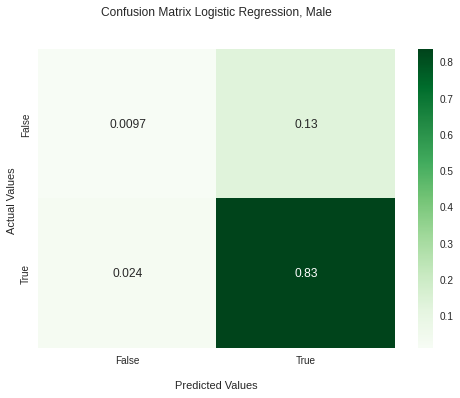

In [228]:
ax = sns.heatmap(cmm_reg/np.sum(cmm_reg), annot=True,  cmap="Greens")
ax.set_title('Confusion Matrix Logistic Regression, Male\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

### Leveling the data between men and women

Minimum error:- 0.1925133689839572 at K = 6
Minimum error:- 0.15591397849462366 at K = 4
Minimum error:- 0.1989247311827957 at K = 6
Minimum error:- 0.16129032258064516 at K = 4
Minimum error:- 0.15591397849462366 at K = 6
Model: knn
accuracy of each fold - [0.8021390374331551, 0.8387096774193549, 0.7956989247311828, 0.8333333333333334, 0.8440860215053764]
Avg accuracy : 0.8227933988844806
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        29
           1       0.84      1.00      0.92       157

    accuracy                           0.84       186
   macro avg       0.42      0.50      0.46       186
weighted avg       0.71      0.84      0.77       186



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Model: lda
accuracy of each fold - [0.8128342245989305, 0.8655913978494624, 0.8387096774193549, 0.8709677419354839, 0.8440860215053764]
Avg accuracy : 0.8464378126617216
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        29
           1       0.84      1.00      0.92       157

    accuracy                           0.84       186
   macro avg       0.42      0.50      0.46       186
weighted avg       0.71      0.84      0.77       186

Model: reg
accuracy of each fold - [0.8288770053475936, 0.8494623655913979, 0.8387096774193549, 0.8548387096774194, 0.8279569892473119]
Avg accuracy : 0.8399689494566156
              precision    recall  f1-score   support

           0       0.33      0.10      0.16        29
           1       0.85      0.96      0.90       157

    accuracy                           0.83       186
   macro avg       0.59      0.53      0.53       186
weighted avg       0.77      0.83      0.79       186

Minimu

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Model: lda
accuracy of each fold - [0.8083832335329342, 0.8313253012048193, 0.8253012048192772, 0.8433734939759037, 0.8253012048192772]
Avg accuracy : 0.8267368876704424
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        29
           1       0.83      1.00      0.90       137

    accuracy                           0.83       166
   macro avg       0.41      0.50      0.45       166
weighted avg       0.68      0.83      0.75       166

Model: reg
accuracy of each fold - [0.8203592814371258, 0.8192771084337349, 0.8192771084337349, 0.8313253012048193, 0.8192771084337349]
Avg accuracy : 0.82190318158863
              precision    recall  f1-score   support

           0       0.43      0.10      0.17        29
           1       0.84      0.97      0.90       137

    accuracy                           0.82       166
   macro avg       0.63      0.54      0.53       166
weighted avg       0.77      0.82      0.77       166

Minimum 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Model: lda
accuracy of each fold - [0.7637795275590551, 0.7777777777777778, 0.746031746031746, 0.7936507936507936, 0.7857142857142857]
Avg accuracy : 0.7733908261467316
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.79      1.00      0.88        99

    accuracy                           0.79       126
   macro avg       0.39      0.50      0.44       126
weighted avg       0.62      0.79      0.69       126

Model: reg
accuracy of each fold - [0.7716535433070866, 0.7698412698412699, 0.7142857142857143, 0.7936507936507936, 0.7777777777777778]
Avg accuracy : 0.7654418197725283
              precision    recall  f1-score   support

           0       0.43      0.11      0.18        27
           1       0.80      0.96      0.87        99

    accuracy                           0.78       126
   macro avg       0.61      0.54      0.52       126
weighted avg       0.72      0.78      0.72       126

Minimum

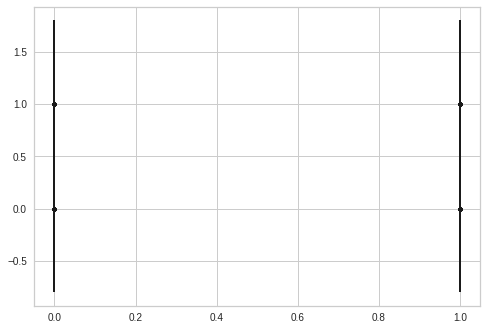

In [229]:
deletion_rate = [100,200,300,400,500]
model_name = ['knn','lda', 'cmm']
cmms_knn_del = []
cmms_lda_del = []
cmms_reg_del = []

for x in deletion_rate:
  ind = df[df['Male'] == 1].sample(x).index
  model_df = df.drop(ind, axis = 0)
  model_df = model_df.reset_index(drop=True)
  model_df = model_df.iloc[: , 1:]
  X = model_df.drop(['Male', 'Female'], axis = 1)
  y = model_df['Male']

  #knn
  cmm_knn_del = model(X, y, 5, "knn", 1)
  cmms_knn_del.append(cmm_knn_del)

  #lda
  cmm_lda_del = model(X, y, 5, "lda", 1)
  cmms_lda_del.append(cmm_lda_del)

  #reg
  cmm_reg_del = model(X, y, 5, "reg", 1)
  cmms_reg_del.append(cmm_reg_del)


In [230]:
att_acc = pd.DataFrame({'Accuracy' : accuracies_knn,
                        'LDA' : accuracies_lda,
                        'REG' : accuracies_reg})

att_acc = att_acc.T
att_acc.columns = attributes

# ATTRIBUTES

For deletion rate 0.5617977528089888
Minimum error:- 0.27102803738317754 at K = 6
Minimum error:- 0.27358490566037735 at K = 7
Minimum error:- 0.330188679245283 at K = 6
Minimum error:- 0.29245283018867924 at K = 5
Minimum error:- 0.19811320754716982 at K = 8
Model: knn
accuracy of each fold - [0.6915887850467289, 0.7264150943396226, 0.6698113207547169, 0.660377358490566, 0.8018867924528302]
Avg accuracy : 0.7100158702168928
              precision    recall  f1-score   support

           0       0.65      0.48      0.55        27
           1       0.84      0.91      0.87        79

    accuracy                           0.80       106
   macro avg       0.74      0.70      0.71       106
weighted avg       0.79      0.80      0.79       106

Model: lda
accuracy of each fold - [0.7009345794392523, 0.7169811320754716, 0.7169811320754716, 0.7452830188679245, 0.6981132075471698]
Avg accuracy : 0.715658614001058
              precision    recall  f1-score   support

           0       0

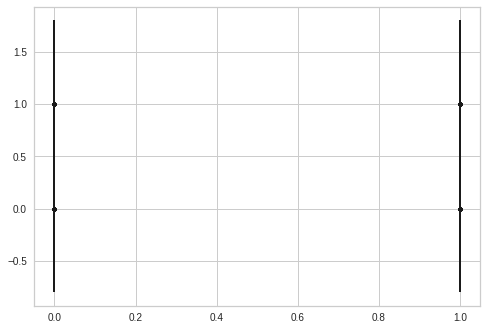

In [231]:
# Keeping the dataset with the best gender distribution
ind = df[df['Male'] == 1].sample(500).index
model_df = df.drop(ind, axis = 0)
model_df = model_df.reset_index(drop=True)
model_df = model_df.iloc[: , 1:]
X = model_df.drop(['Male', 'Female'], axis = 1)
y = model_df['Male']
print("For deletion rate", 500/males)
cm_knn_del, rep_knn_model = model(X, y, 5, "knn", 1)
cm_lda_del, rep_lda_model = model(X, y, 5, "lda", 1)
cm_reg_del,rep_reg_model = model(X, y, 5, "reg", 1)

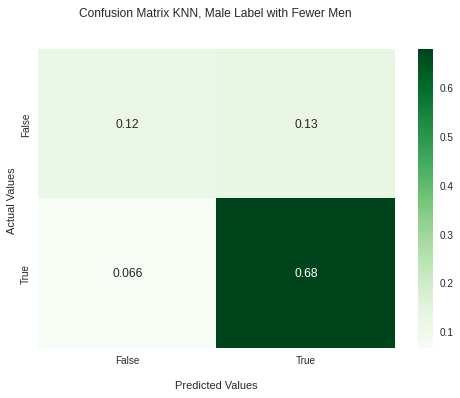

In [232]:
ax = sns.heatmap(cm_knn_del/np.sum(cm_knn_del), annot=True,  cmap="Greens")
ax.set_title('Confusion Matrix KNN, Male Label with Fewer Men \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [233]:
print(rep_knn_model)

              precision    recall  f1-score   support

           0       0.65      0.48      0.55        27
           1       0.84      0.91      0.87        79

    accuracy                           0.80       106
   macro avg       0.74      0.70      0.71       106
weighted avg       0.79      0.80      0.79       106



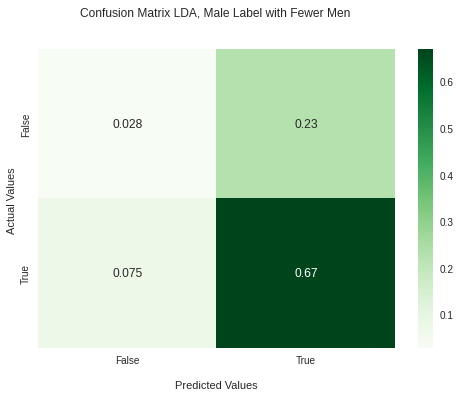

In [234]:
ax = sns.heatmap(cm_lda_del/np.sum(cm_lda_del), annot=True,  cmap="Greens")
ax.set_title('Confusion Matrix LDA, Male Label with Fewer Men \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [235]:
print(rep_lda_model)

              precision    recall  f1-score   support

           0       0.27      0.11      0.16        27
           1       0.75      0.90      0.82        79

    accuracy                           0.70       106
   macro avg       0.51      0.50      0.49       106
weighted avg       0.63      0.70      0.65       106



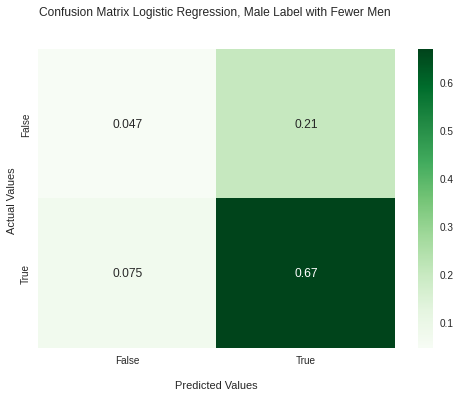

In [236]:
ax = sns.heatmap(cm_reg_del/np.sum(cm_reg_del), annot=True,  cmap="Greens")
ax.set_title('Confusion Matrix Logistic Regression, Male Label with Fewer Men \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [237]:
print(rep_reg_model)

              precision    recall  f1-score   support

           0       0.38      0.19      0.25        27
           1       0.76      0.90      0.83        79

    accuracy                           0.72       106
   macro avg       0.57      0.54      0.54       106
weighted avg       0.67      0.72      0.68       106



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

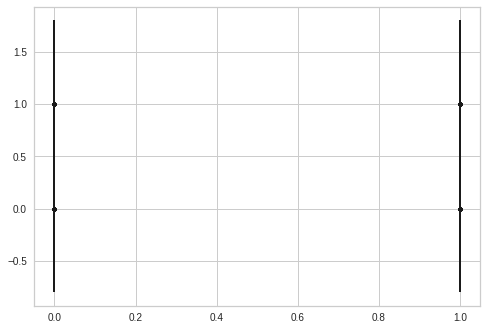

In [238]:
accuracies_knn  = []
accuracies_lda  = []
accuracies_reg  = []

attributes = list(X.columns.values)
X = model_df.drop(['Male', 'Female'], axis = 1)
y = model_df['Male']
for x in attributes:
  dummy_df = X.drop(x, axis = 1)
  #print("For feature ", x)
  # knn
  acc_knn, rep_knn, cm_knn = model(dummy_df, y, 5, "knn",0)
  accuracies_knn.append(acc_knn)

  #lda
  acc_lda, rep_lda, cm_lda = model(dummy_df, y, 5, "lda",0)
  accuracies_lda.append(acc_lda)

  #reg
  acc_reg, rep_reg, cm_reg = model(dummy_df, y, 5, "reg",0)
  accuracies_reg.append(acc_reg)

In [239]:
accuracies_knn = [x - acc_knn for x in accuracies_knn]
accuracies_lda = [x - acc_lda for x in accuracies_lda]
accuracies_reg = [x - acc_reg for x in accuracies_reg]

In [240]:
att_acc = pd.DataFrame({'Knn' : accuracies_knn,
                        'LDA' : accuracies_lda,
                        'REG' : accuracies_reg})

att_acc = att_acc.T
att_acc.columns = attributes

In [241]:
att_acc = att_acc.T

In [242]:
att_acc

,Knn,LDA,REG
YearsExperienceGermany,0.000000,0.005660,-3.773585e-03
MainSkill,-0.001940,0.000000,-3.738318e-03
SecondarySkills,0.007565,0.013208,0.000000e+00
BrutSalary,0.011321,-0.003774,1.110223e-16
BrutSalaryAndStocks,-0.005660,0.018868,1.886792e-03
AnnualBrutLastYear,0.022536,0.015094,-3.773585e-03
AnnualBrutAndStocksLastYear,0.016963,0.007547,-1.886792e-03
VacationDays,0.000000,0.011321,1.886792e-03
CompanySize,0.024458,0.005660,-9.433962e-03
CompanyType,0.018780,0.007547,1.110223e-16


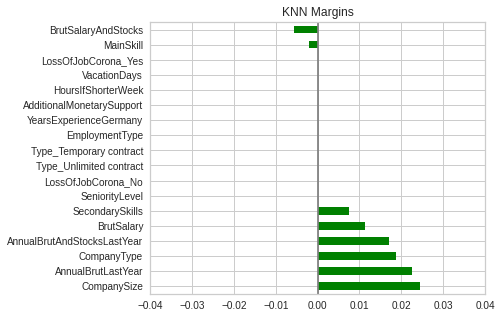

In [243]:
att_acc_knn = att_acc['Knn']
att_acc_knn = att_acc_knn.reindex(att_acc_knn.sort_values(ascending=False).index)
ax = att_acc_knn.plot(kind='barh', figsize=(6, 5), color='green')
plt.title('KNN Margins')
plt.xlim(-0.04, 0.04)
plt.axvline(x=0, color='.5')

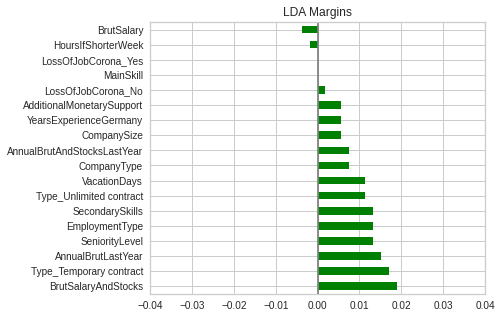

In [244]:
att_acc_lda = att_acc['LDA']
att_acc_lda = att_acc_lda.reindex(att_acc_lda.sort_values(ascending=False).index)
ax = att_acc_lda.plot(kind='barh', figsize=(6, 5), color='green')
plt.title('LDA Margins')
plt.xlim(-0.04, 0.04)
plt.axvline(x=0, color='.5')

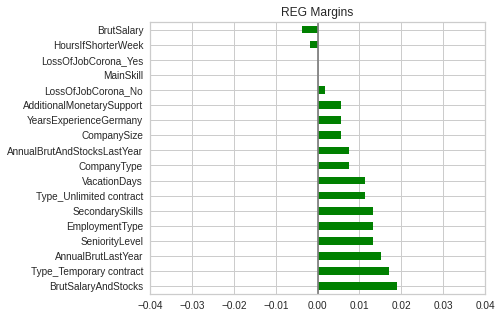

In [245]:
att_acc_reg = att_acc['LDA']
att_acc_reg = att_acc_reg.reindex(att_acc_reg.sort_values(ascending=False).index)
ax = att_acc_reg.plot(kind='barh', figsize=(6, 5), color='green')
plt.title('REG Margins')
plt.xlim(-0.04, 0.04)
plt.axvline(x=0, color='.5')

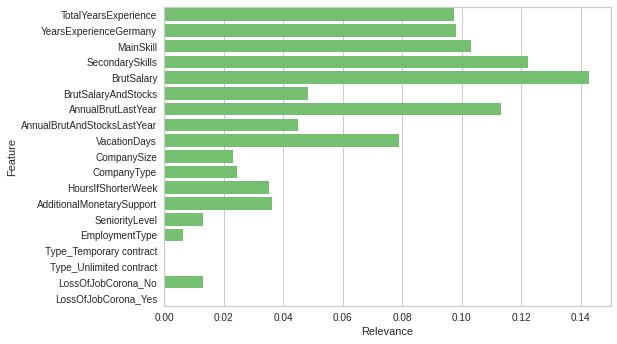

In [246]:
#Evaluate importance of variables
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()

X = df.drop(['Male', 'Female'], axis = 1)
Y = df['Male']
clf.fit(X, Y)
importances = list(clf.feature_importances_)
indices = np.argsort(importances)[::-1]
feature_names = list(X.columns)


imp = pd.DataFrame(zip(feature_names,importances), columns =['Feature', 'Relevance'])

p = sns.set_color_codes("muted")
p = sns.barplot(x='Relevance', y='Feature', data=imp, color="g")

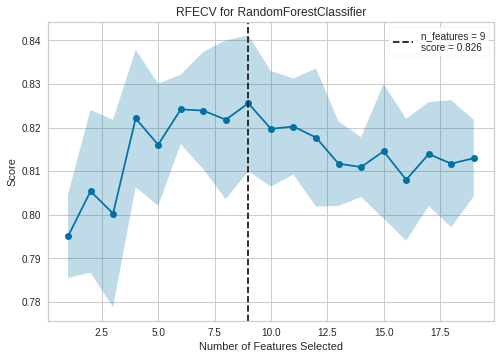

In [247]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import RFECV


cv = StratifiedKFold(5)
visualizer = RFECV(RandomForestClassifier(), cv=cv, scoring='f1_weighted')

visualizer.fit(X, Y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure